## Voronoi Plots Iteration 2

In [1]:
import scipy.spatial
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import networkx as nx
from math import sqrt, pi, isclose

In [2]:
def ccw(A,B,C):
    Ax,Ay=A
    Bx,By=B
    Cx,Cy=C
    return (Cy-Ay) * (Bx-Ax) > (By-Ay) * (Cx-Ax)

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def edge_intersect(E,F):
    A,B = E
    C,D = F
    return intersect(A,B,C,D)

def line_intersection(E, F):
    xdiff = (E[0][0] - E[1][0], F[0][0] - F[1][0])
    ydiff = (E[0][1] - E[1][1], F[0][1] - F[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*E), det(*F))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def sign(v):
    if isclose(v,0):
        return 0
    elif v>0:
        return 1
    elif v<0:
        return -1

def point_is_LR_of_line(p, line):
    x,y=p
    A,B = line
    Ax,Ay=A
    Bx,By=B
    position = sign((Bx-Ax)*(y-Ay) - (By-Ay) * (x-Ax))
    if position is None:
        print("no side", p)
        return 0
    return position

def centroid_of_shape(S):
    length=len(S)
    if length > 0:
        mean_x=sum([x for x,y in S])/length
        mean_y=sum([y for x,y in S])/length
        if mean_x is None or mean_y is None:
            print(S, "no centroid")
        return [mean_x, mean_y]
    else:
        return None

def split_shape(S,line):
    s_boundaries=[(S[i-1], S[i]) for i,s in enumerate(S)]
    shape_lines_and_cuts = [(e,edge_intersect(l, line), l, line_intersection(l, line) if edge_intersect(l, line) else None) for e,l in enumerate(s_boundaries)]
    s1=[]
    s2=[]
    switch=False
    if len([c for c in shape_lines_and_cuts if c[1]])>0:
        for e,x,l,c in shape_lines_and_cuts:
            #print(e,x,l,c)
            if x:
                
                if not switch:
                    p1=np.array(c)
                    s1.append([p1,l[1]])
                    s2.append([l[0],p1])
                    switch=True
                else:
                    p2=np.array(c)
                    s1.append([l[0],p2])
                    s1.append([p2, p1])
                    
                    s2.append([p1,p2])
                    s2.append([p2,l[1]])
    
                    switch=False
            else:
                    
                if switch:
                    s1.append(l)
                else:
                    pass
                    s2.append(l)

        lhs=[]
        rhs=[]
        centroid=centroid_of_shape([f for f,s in s1])
        if centroid is not None:
            if point_is_LR_of_line(centroid,line)>=0:
                lhs=s1
            else:
                rhs=s1
                
        centroid=centroid_of_shape([f for f,s in s2])
        if centroid is not None:
            if point_is_LR_of_line(centroid,line)<=0:
                rhs=s2
            else:
                lhs=s2
    else:
        lhs=[]
        rhs=[]
        centroid=centroid_of_shape([f for f,s in s_boundaries])
        if centroid is not None:
            if point_is_LR_of_line(centroid,line)>=0:
                lhs=s_boundaries
                rhs=[]
            else:
                rhs=s_boundaries
                lhs=[]
    
    return [f for f,s in lhs][0:],[f for f,s in rhs][0:]

In [3]:
def shapes_from_voronoi(V):
    live_regions = [V.regions[r] for r in V.point_region]
    shapes=[]
    for e,r in enumerate(live_regions) :
        #print(e,r)
        shape=[]
        for v in r:
            if v == -1:
                shape.append(np.array([-np.inf, -np.inf]))
            else:
                shape.append(V.vertices[v])
        if ~any([v==-1 for v in r]):
            shapes.append(np.array(shape))
    return shapes

In [4]:
space_dims = (400,400)

number_of_points = 2000

In [5]:

boundary_points=[]
c=0
for x in np.linspace(0, space_dims[0],3):
    c=-space_dims[1]
    boundary_points.append(np.array([x,c]))
c=0
for x in np.linspace(0, space_dims[0],3):
    c=space_dims[1]*2
    boundary_points.append(np.array([x,c]))
x=0
for c in np.linspace(0, space_dims[1],3):
    x=-space_dims[0]
    boundary_points.append(np.array([x,c]))
x=0
for c in np.linspace(0, space_dims[1],3):
    x=space_dims[0]*2
    boundary_points.append(np.array([x,c]))


boundary_points=np.array(boundary_points).T

bpl=len(boundary_points)

In [6]:

rand_point_coords = np.array([np.random.randint(0,space_dims[0],number_of_points),np.random.randint(0,space_dims[1],number_of_points)])

unique_rand_point_coords = list(set([tuple(c) for c in rand_point_coords.T]))
number_of_points = len(unique_rand_point_coords)
unique_rand_point_coords = np.array(unique_rand_point_coords).T
pdist=scipy.spatial.distance.cdist(unique_rand_point_coords.T, unique_rand_point_coords.T)

number_of_points

1981

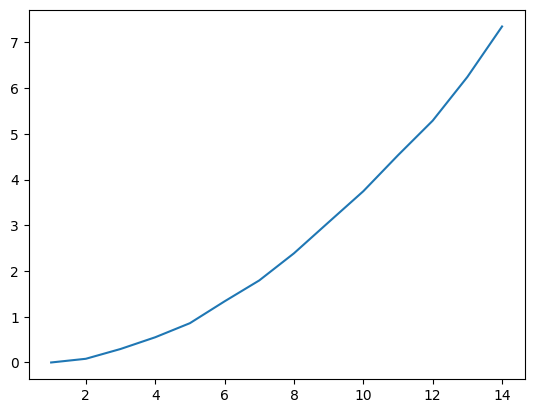

In [7]:

xs=[]
ys=[]
zs=[]
d_vals=[]
for d in range(1,int(sqrt((space_dims[0]**2)+(space_dims[1]**2))/(number_of_points/200))):
    xs.append(d)
    links=np.array(np.where((pdist>0)&(pdist<d))).T
    dg=nx.Graph()
    for f,t in links:
        if f<t:
            dg.add_edge(int(f),int(t))
    ys.append(len(dg.edges()))
    dgdegree=[v for k,v in dg.degree()]
    avg_degree=sum(dgdegree)/number_of_points
    zs.append(avg_degree)
    #print(d, "\t", avg_degree)
    if avg_degree > (pi*2):
        break
    d_vals.append((d,avg_degree))  
plt.plot(xs,zs)
try:
    chosen_d=[d for d,v in d_vals if v>pi][0]
except:
    chosen_d=0

In [8]:
chosen_d

10

In [9]:
#chosen_d=2

In [10]:
links=np.array(np.where((pdist>0)&(pdist<chosen_d))).T
dg=nx.Graph()
for cell in range(len(unique_rand_point_coords.T)):
    dg.add_node(cell)
    #print(cell)
for f,t in links:
    if f<t:
        dg.add_edge(int(f),int(t))

In [11]:
point_coords= np.hstack([unique_rand_point_coords, 
                         boundary_points])

vor = scipy.spatial.Voronoi(point_coords.T, furthest_site=False)
delaunay = scipy.spatial.Delaunay(point_coords.T, furthest_site=False)

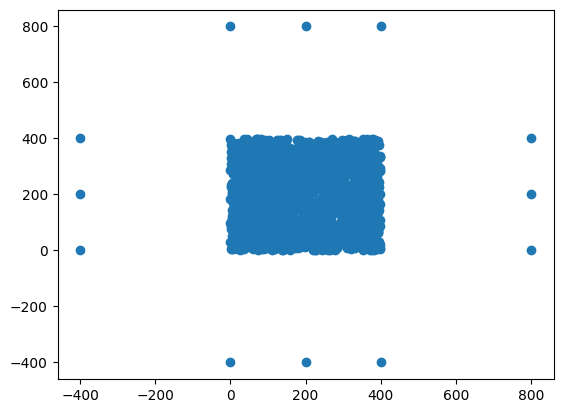

In [12]:
plt.scatter(*point_coords)

<Figure size 640x480 with 0 Axes>

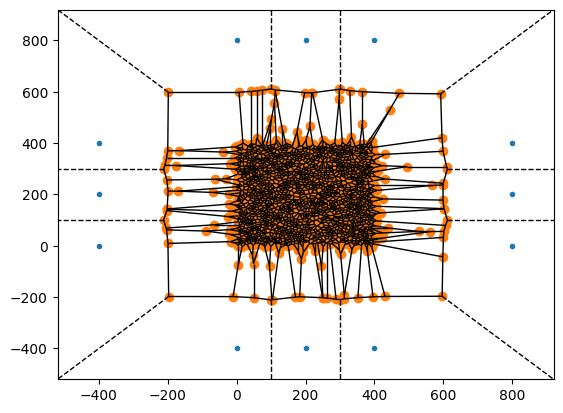

In [13]:
fig = plt.figure()
ax = scipy.spatial.voronoi_plot_2d(vor, alpha=0.5)
#ax = plt.rect(0,0,200,200)
#plt.xlim(-200,600)
#plt.ylim(-200,600)


In [14]:
live_regions = [vor.regions[r] for r in vor.point_region[0:number_of_points]]

In [15]:
vor.point_region[6]

965

In [16]:
shapes=shapes_from_voronoi(vor)

In [17]:
len(shapes)

1993

In [18]:
len(live_regions)

1981

In [19]:
border_facets=dict()
for i,r in enumerate(live_regions):
    for j in range(len(r)):
        border = tuple(sorted((r[j], r[j-1])))
                           
        if border in border_facets.keys() :
            if not any([b==-1 for b in border]):
                border_facets[border].append(i)
                #print(i, border)
        else:
            border_facets[border]=[i]
# Create graph containing all cells connected by borders
rg = nx.Graph()
for k,v in border_facets.items():
    if len(v)>1:
        rg.add_edge(int(v[0]), int(v[1]))


In [20]:
[(k,v) for k,v in border_facets.items() if 1589 in v]

[((870, 871), [140, 1589]),
 ((870, 1530), [409, 1589]),
 ((1530, 1531), [960, 1589]),
 ((871, 894), [1009, 1589]),
 ((893, 894), [1472, 1589]),
 ((893, 1531), [1589, 1797])]

(-300.0, 700.0)

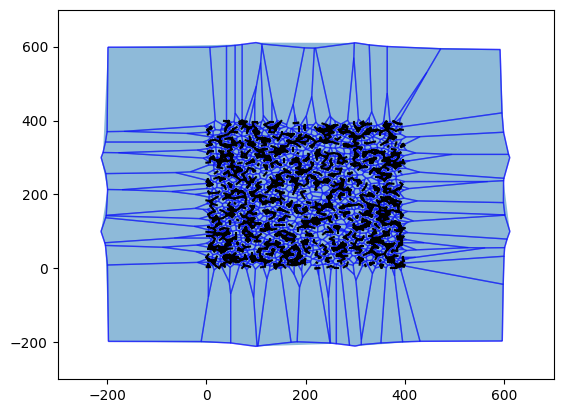

In [21]:
fig, ax = plt.subplots()
#for e,r in enumerate(vor.point_region) :
for e,r in enumerate(shapes) :
    #print(e,r)
    shape=shapes[e] 
    ax.add_patch(mpatches.Polygon(np.array(shape), edgecolor='blue', alpha=0.5))
    
for f,t in dg.edges():
    x1y1=vor.points[f][0], vor.points[f][1]
    x2y2=vor.points[t][0], vor.points[t][1]
    plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='k')
plt.xlim(-300,700)
plt.ylim(-300,700)

In [22]:
cut_lines = [[[-space_dims[0]*2, 0], [space_dims[0]*2, 0]],
            [[space_dims[0], -space_dims[1]*2], [space_dims[0], space_dims[1]*2]],
            [[space_dims[0]*2, space_dims[1]], [-space_dims[0]*2, space_dims[1]]],
            [[0, space_dims[1]*2], [0, -space_dims[1]*2]]]

In [23]:

for c in cut_lines:
    #print(c)
    for e,s in enumerate(shapes):
        lhs,rhs = split_shape(s,c)
        shapes[e]=lhs


/tmp/ipykernel_23710/1197178701.py:45: RuntimeWarning: invalid value encountered in scalar multiply
  position = sign((Bx-Ax)*(y-Ay) - (By-Ay) * (x-Ax))
/tmp/ipykernel_23710/1197178701.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  return a[0] * b[1] - a[1] * b[0]
/tmp/ipykernel_23710/1197178701.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  return a[0] * b[1] - a[1] * b[0]


no side [-inf, -inf]
no side [-inf, -inf]
no side [-inf, -inf]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]
no side [-inf, -inf]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]
no side [-inf, -inf]
no side [nan, nan]
no side [nan, nan]
no side [nan, nan]


(-20.0, 420.0)

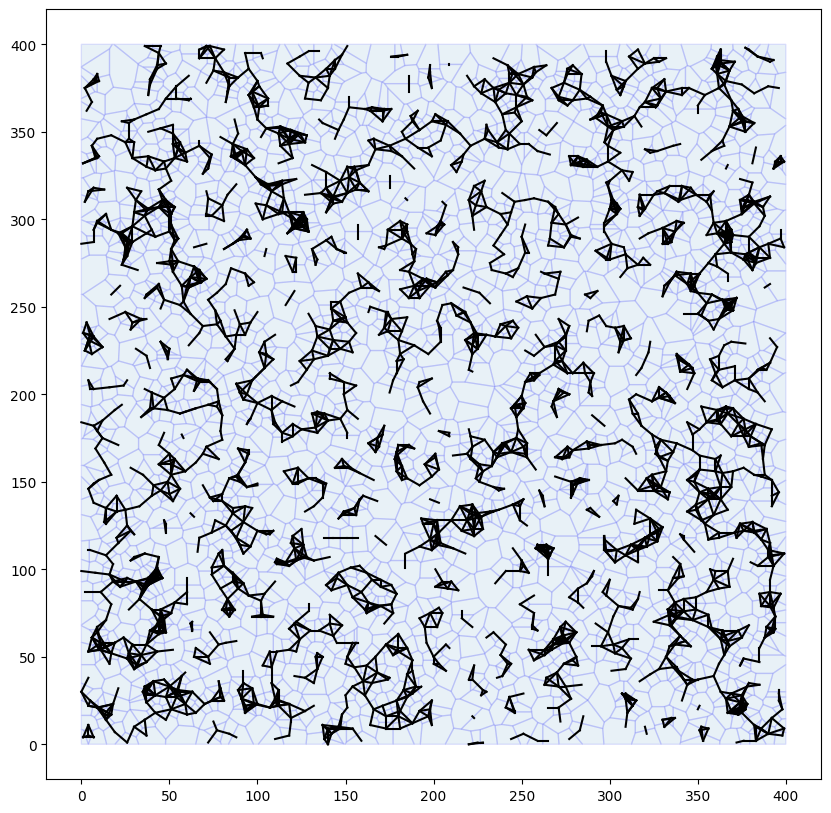

In [24]:
fig=plt.figure(figsize=(10,10))
ax = plt.gca()
#for e,r in enumerate(vor.point_region) :
for e,r in enumerate(shapes) :
    shape=shapes[e] 
    if len(shape)>0:
        ax.add_patch(mpatches.Polygon(np.array(shape), edgecolor='blue', alpha=0.1))
    
for f,t in dg.edges():
    x1y1=vor.points[f][0], vor.points[f][1]
    x2y2=vor.points[t][0], vor.points[t][1]
    plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='k')
plt.xlim(-20,420)
plt.ylim(-20,420)

In [1]:
shape

NameError: name 'shape' is not defined

In [25]:
all_connected = {s for r in nx.connected_components(dg) for s in r}
singletons = [set([s]) for s in set(rg.nodes()) if s not in all_connected]
region_sets = list(nx.connected_components(dg)) + singletons


region_graph=nx.Graph()
for e,r in enumerate(region_sets):
    neighbourset=set()
    for n in r:
        if n in rg.nodes():
            neighbourset.update(rg.neighbors(n))
    for f,r_two in enumerate(region_sets):
        if e!=f:
            if len(neighbourset.intersection(r_two))>0:
                region_graph.add_edge(e,f)


1981 [array([  49.        , -201.83416459]), array([ 100.        , -210.99127182]), array([  -0.        , -206.45986082]), array([  -0.        , -198.65710723])]
1982 [array([ 102.17355105, -210.29746999]), array([ 100.        , -210.99127182]), array([ 300.        , -210.25062035]), array([ 288.54685858, -208.062303  ]), array([ 262.       , -203.7699005]), array([ 250.06510522, -202.01826171]), array([ 249.3081761 , -201.96540881]), array([ 182.95417349, -198.64770867]), array([ 170.64766839, -199.90284974]), array([ 103.85786802, -209.9213198 ])]
1983 [array([ 351.79534976, -201.88835463]), array([ 395.71108358, -198.82191935])]
1984 []
1985 []
1986 []
1987 []
1988 []
1989 []
1990 [array([ 596.52457002, -196.52457002]), array([598.43428394, -42.98357099]), array([599.39900249,  -0.        ]), array([nan, nan]), array([-inf, -inf])]
1991 []
1992 []


(-20.0, 420.0)

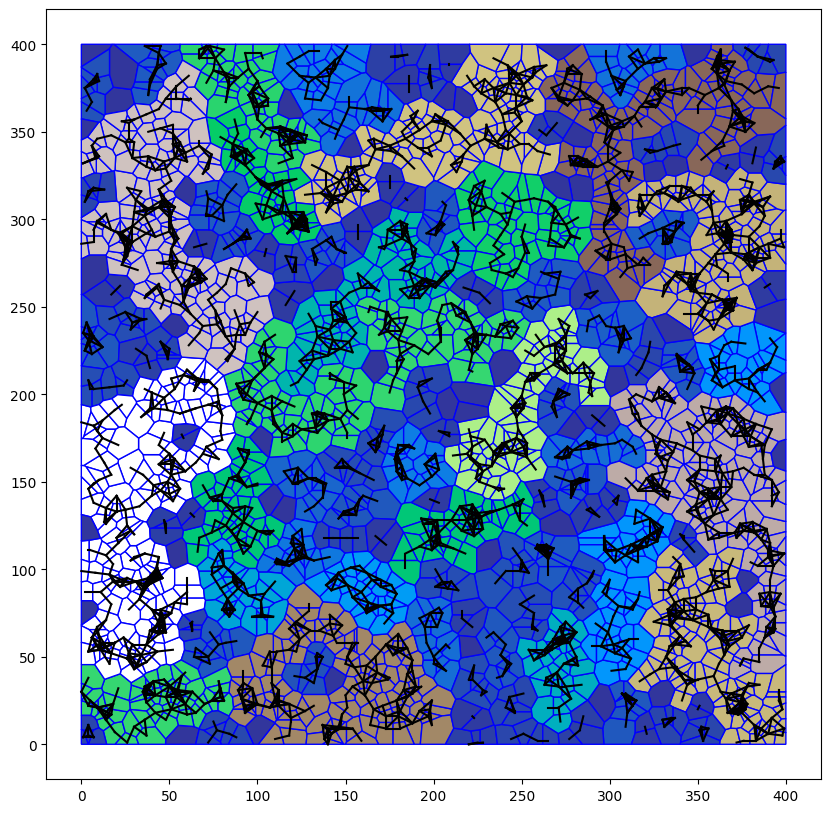

In [26]:
cmap = plt.get_cmap('gist_rainbow')
cmap = plt.get_cmap('terrain')
#cmap = plt.get_cmap('gist_ncar')
#cmap = plt.get_cmap('nipy_spectral')
#cmap = plt.get_cmap('jet')
norm=plt.Normalize(0,max([len(r) for e,r in enumerate(region_sets)]))
colours = [cmap(norm(len(r))) for e,r in enumerate(region_sets)]

fig=plt.figure(figsize=(10,10))
ax = plt.gca()
#for e,r in enumerate(vor.point_region) :
for e,r in enumerate(shapes) :
    shape=shapes[e] 
    try:
        region=[i for i,r in enumerate(region_sets) if e in r][0]
        if len(shape)>0:
            ax.add_patch(mpatches.Polygon(np.array(shape), edgecolor='blue', facecolor=colours[region], alpha=1.0))
    except:
        print(e,r)
for f,t in dg.edges():
    x1y1=vor.points[f][0], vor.points[f][1]
    x2y2=vor.points[t][0], vor.points[t][1]
    plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='k')
    
plt.xlim(-20,420)
plt.ylim(-20,420)

(-20.0, 420.0)

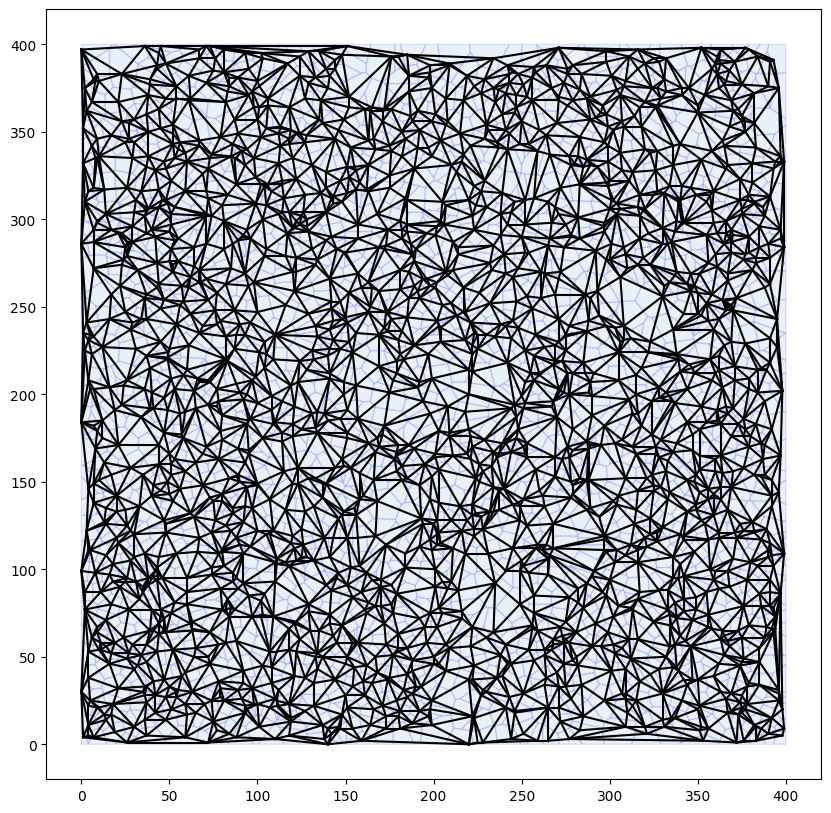

In [27]:
fig=plt.figure(figsize=(10,10))
ax = plt.gca()
#for e,r in enumerate(vor.point_region) :
for e,r in enumerate(shapes) :
    shape=shapes[e] 
    if len(shape)>0:
        ax.add_patch(mpatches.Polygon(np.array(shape), edgecolor='blue', alpha=0.1))
    
for f,t in rg.edges():
    x1y1=vor.points[f][0], vor.points[f][1]
    x2y2=vor.points[t][0], vor.points[t][1]
    plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='k')
plt.xlim(-20,420)
plt.ylim(-20,420)

In [28]:
def bicolour_regions(graph):
    processed=set()
    assignments=dict()
    regions_by_size=sorted([(k,v) for k,v in graph.degree()], key=lambda x : x[1], reverse=True)
    r = regions_by_size[0][0]
    
    for r,s in regions_by_size:
        if r not in processed:
            processed.add(r)
            assignments[r]=0
            for a in graph.neighbors(r):
                if a not in processed:
                    processed.add(a)
                    assignments[a]=1
    return assignments
            

In [29]:
region_lookup = {c:e for e,v in enumerate(region_sets) for c in v}

region_colors_lookup = bicolour_regions(region_graph)

cell_region_colour_lookup = {k:region_colors_lookup.get(v) for k,v in region_lookup.items()}

clist=['forestgreen','cornflowerblue', '2','3','4','5','black']


(-5.0, 405.0)

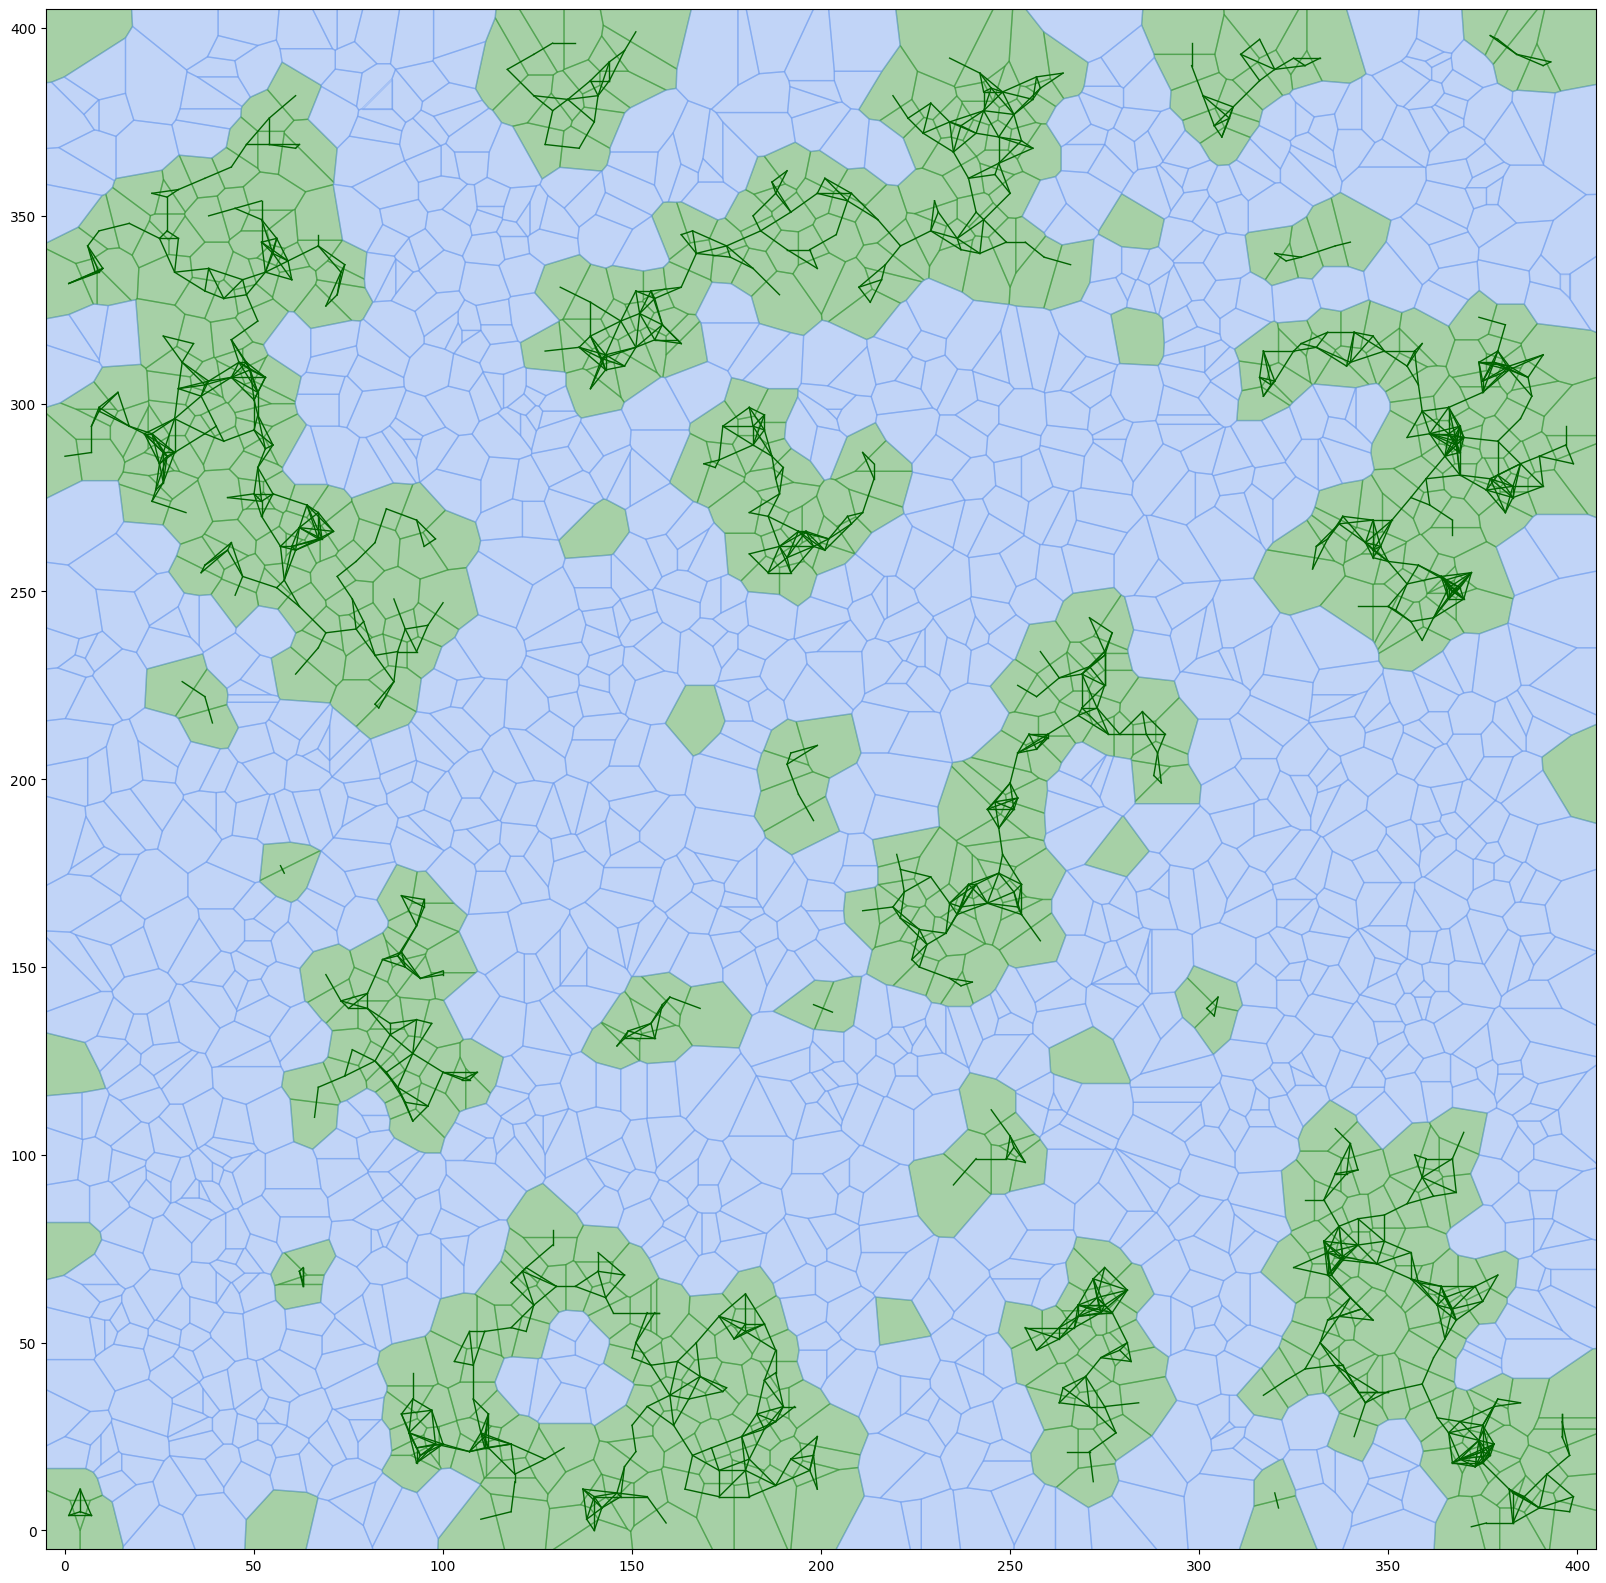

In [30]:
fig=plt.figure(figsize=(20,20))
ax = plt.gca()
live_regions = [vor.regions[r] for r in vor.point_region[0:number_of_points]]
nshapes=[]
land_patches=[]
sea_patches=[]
for e,r in enumerate(live_regions) :
    #print(e,r)
    shape=[]
    for v in r:
        shape.append(vor.vertices[v])

    lpatch=mpatches.Polygon(np.array(shape))
    #lpatch.set_color(mcolors.to_rgb(clist[cell_region_colour_lookup.get(e,6)]))
    if cell_region_colour_lookup.get(e,6)==0:
        land_patches.append(lpatch)
    elif cell_region_colour_lookup.get(e,6)==1:
        sea_patches.append(lpatch)
    #ax.add_patch(lpatch)
    #ax.text(*vor.points[e],e, fontsize=8, color='white')
    nshapes.append(np.array(shape))

pcollection=PatchCollection(land_patches, edgecolor='green', color='forestgreen', alpha=0.4)
ax.add_collection(pcollection)
pcollection=PatchCollection(sea_patches, edgecolor='blue', color='cornflowerblue', alpha=0.4)
ax.add_collection(pcollection)

for f,t in dg.edges():
    if cell_region_colour_lookup.get(f,6)==0:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkgreen',linewidth=1)
    elif cell_region_colour_lookup.get(f,6)==1:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        #plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkblue',linewidth=1)
plt.xlim(-5,405)
plt.ylim(-5,405)

In [31]:
cell_dict = dict()

In [32]:
478 in set(dg.nodes())

True

In [33]:
hdegree_d=dict(dg.degree)

In [34]:
set(rg.nodes()).difference(set(dg.nodes()))

set()

In [35]:
cell_dict = dict()
for cell in rg.nodes():
    cell_dict[cell]={}
    cell_dict[cell]["region"]=region_lookup[cell]
    cell_dict[cell]["bicolour"]=region_colors_lookup[region_lookup[cell]]
    colour_dir = 1 if region_colors_lookup[region_lookup[cell]] == 0 else -1
    cell_dict[cell]["height"]=(hdegree_d.get(cell,0)*colour_dir)-1
    cell_dict[cell]["shape"]=np.array(shapes[cell] )
    cell_dict[cell]["neighbors"]=list(rg.neighbors(cell))
    cell_dict[cell]["link_neighbors"]=list(dg.neighbors(cell))
    cell_dict[cell]['v_point']=vor.points[cell]
    cell_dict[cell]['vertex_indices']=vor.regions[vor.point_region[cell]]
    cell_dict[cell]['vertex_pos']=[vor.vertices[v] for v in vor.regions[vor.point_region[cell]]]


In [36]:
cell_dict[1675]

{'region': 22,
 'bicolour': 0,
 'height': 3,
 'shape': array([[ 61.59090909, 343.5       ],
        [ 61.5       , 343.        ],
        [ 64.72727273, 336.54545455],
        [ 66.2961165 , 335.32524272],
        [ 69.44736842, 338.02631579],
        [ 73.35714286, 343.5       ]]),
 'neighbors': [703, 846, 868, 1003, 1942, 1746],
 'link_neighbors': [846, 1003, 1746, 1942],
 'v_point': array([ 67., 342.]),
 'vertex_indices': [3564, 3280, 2899, 2900, 2898, 3563],
 'vertex_pos': [array([ 69.44736842, 338.02631579]),
  array([ 73.35714286, 343.5       ]),
  array([ 61.59090909, 343.5       ]),
  array([ 61.5, 343. ]),
  array([ 64.72727273, 336.54545455]),
  array([ 66.2961165 , 335.32524272])]}

In [37]:
live_regions[1675]

[3564, 3280, 2899, 2900, 2898, 3563]

In [38]:
heights = [v['height'] for v in cell_dict.values() ]
sea_level = 0
land_heightnorm=plt.Normalize(sea_level, max(heights))
sea_heightnorm=plt.Normalize(min(heights), sea_level)


(array([104., 753., 559., 481.,  84.]),
 array([-12. ,  -7.6,  -3.2,   1.2,   5.6,  10. ]),
 <BarContainer object of 5 artists>)

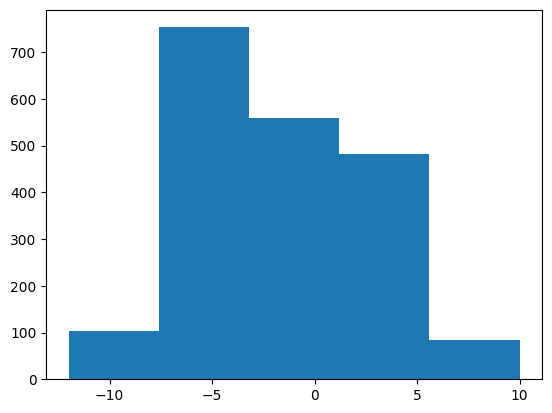

In [39]:
plt.hist(heights, bins=5)

In [40]:
from matplotlib.colors import LinearSegmentedColormap

#land_colors = [(0.6, 1, 0.6), (0.3, 0.8, 0.3), (0.3, 0.3, 0.3)] 
land_colors = [(0.6, 1, 0.6), (0.2, 0.2, 0.2)] 
land_colors_cmap = LinearSegmentedColormap.from_list("land_colors", land_colors, N=16)

#sea_colors = [(0.4, 0.5, 0.9), (0.5, 0.5, 1.0), (0.6, 0.6, 1.0)] 
sea_colors = [(0.1, 0.1, 0.5), (0.6, 0.6, 1.0)] 
sea_colors_cmap = LinearSegmentedColormap.from_list("sea_colors", sea_colors, N=16)



/tmp/ipykernel_23710/2493317061.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)


(-5.0, 405.0)

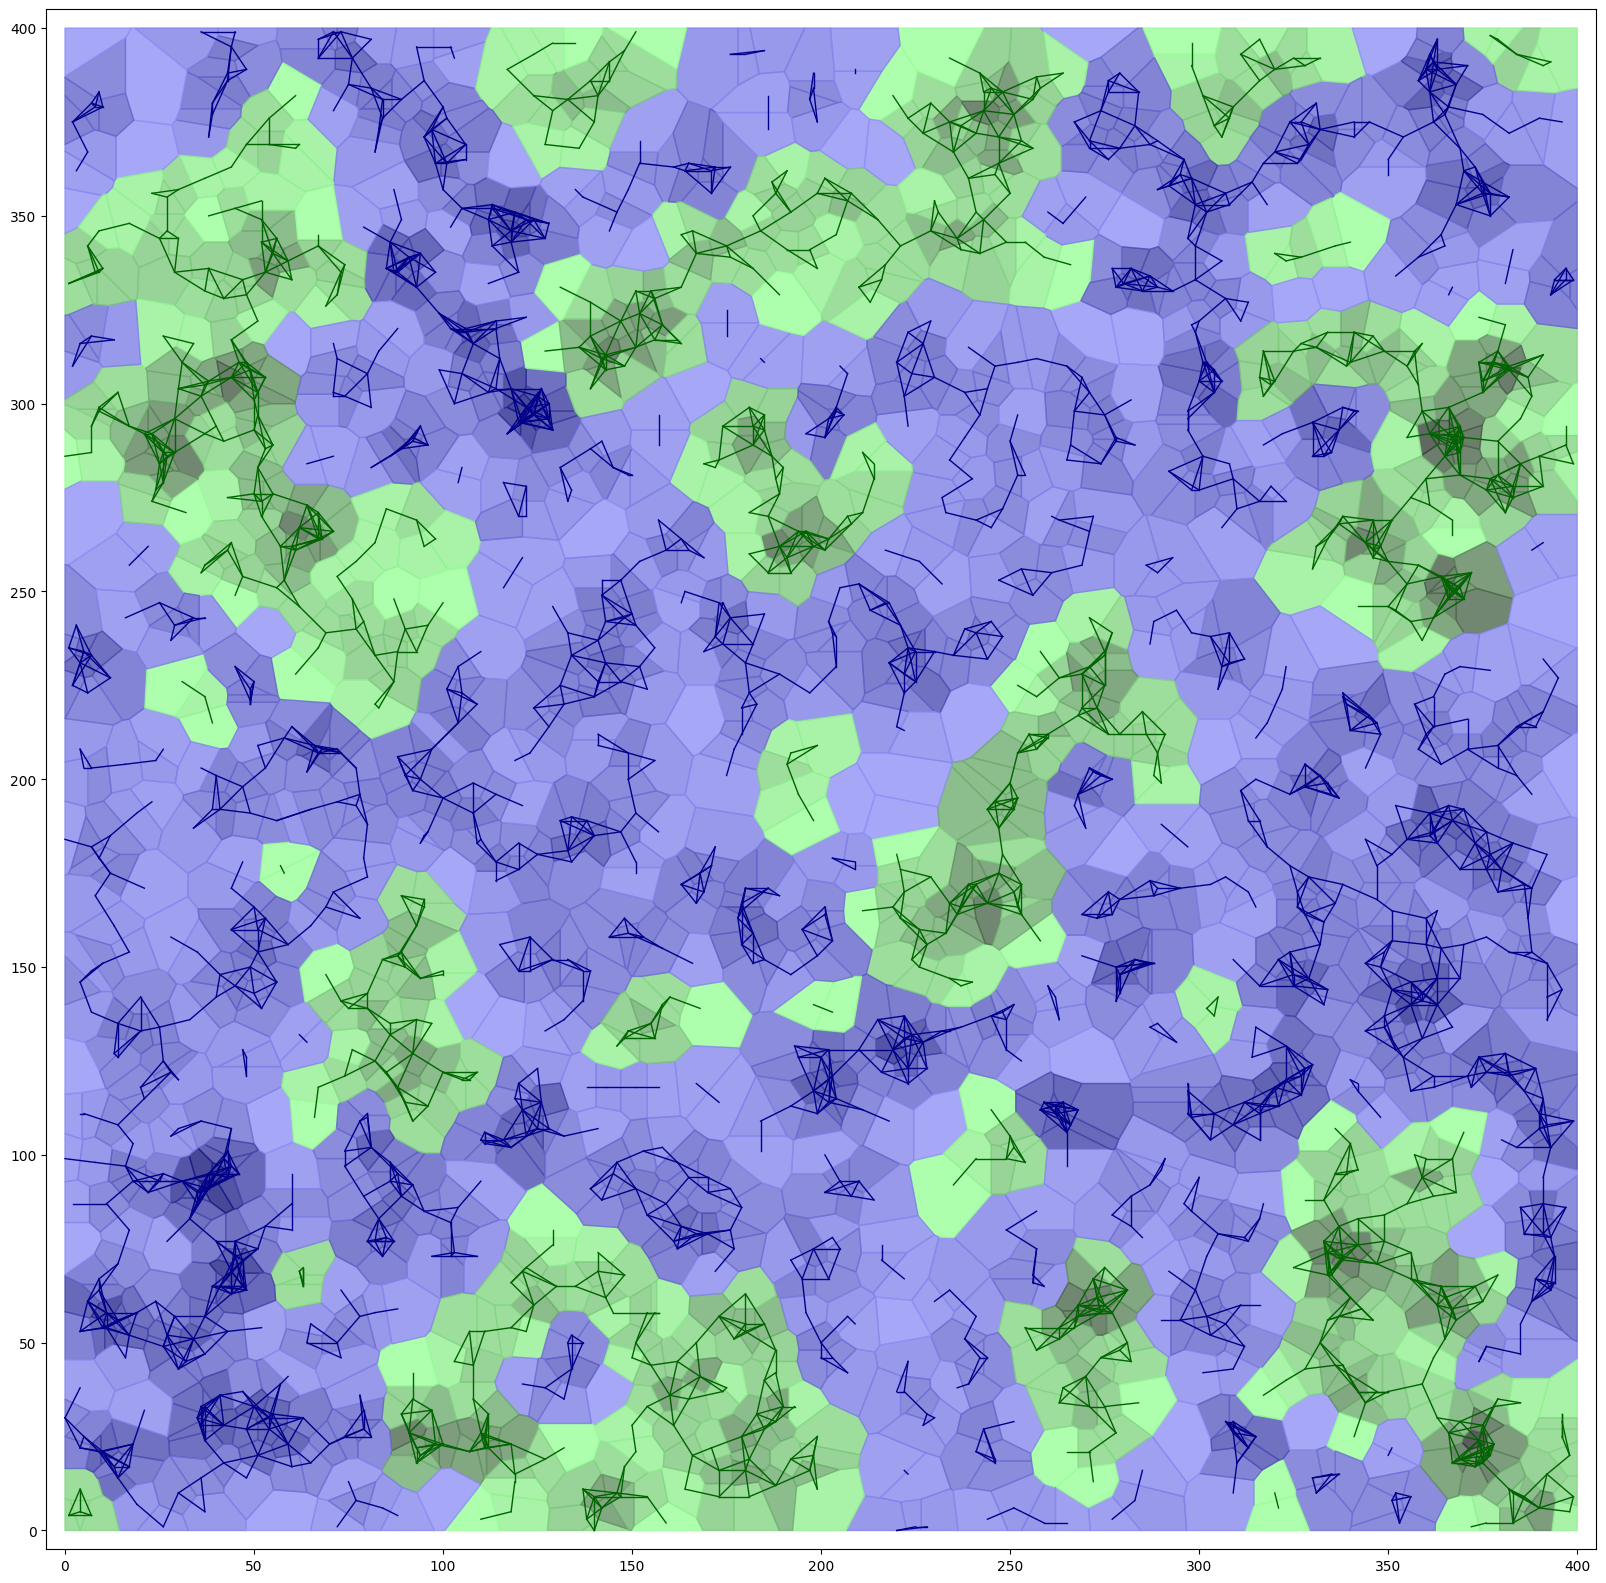

In [41]:
cmap = plt.get_cmap('gist_rainbow')
cmap = plt.get_cmap('summer')
scmap = plt.get_cmap('cool')
#cmap = plt.get_cmap('gist_ncar')
#cmap = plt.get_cmap('nipy_spectral')
#cmap = plt.get_cmap('jet')

fig=plt.figure(figsize=(20,20))
ax = plt.gca()

for cell, data in cell_dict.items():
    if data['height']>=sea_level:
        cvalue = land_colors_cmap(land_heightnorm(data['height']))
    else:
        cvalue = sea_colors_cmap(sea_heightnorm(data['height']))
    patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)
    ax.add_patch(patch)


for f,t in dg.edges():
    if cell_region_colour_lookup.get(f,6)==0:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkgreen',linewidth=1)
    elif cell_region_colour_lookup.get(f,6)==1:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkblue',linewidth=1)

plt.xlim(-5,405)
plt.ylim(-5,405)

/tmp/ipykernel_23710/2493317061.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)


(-5.0, 405.0)

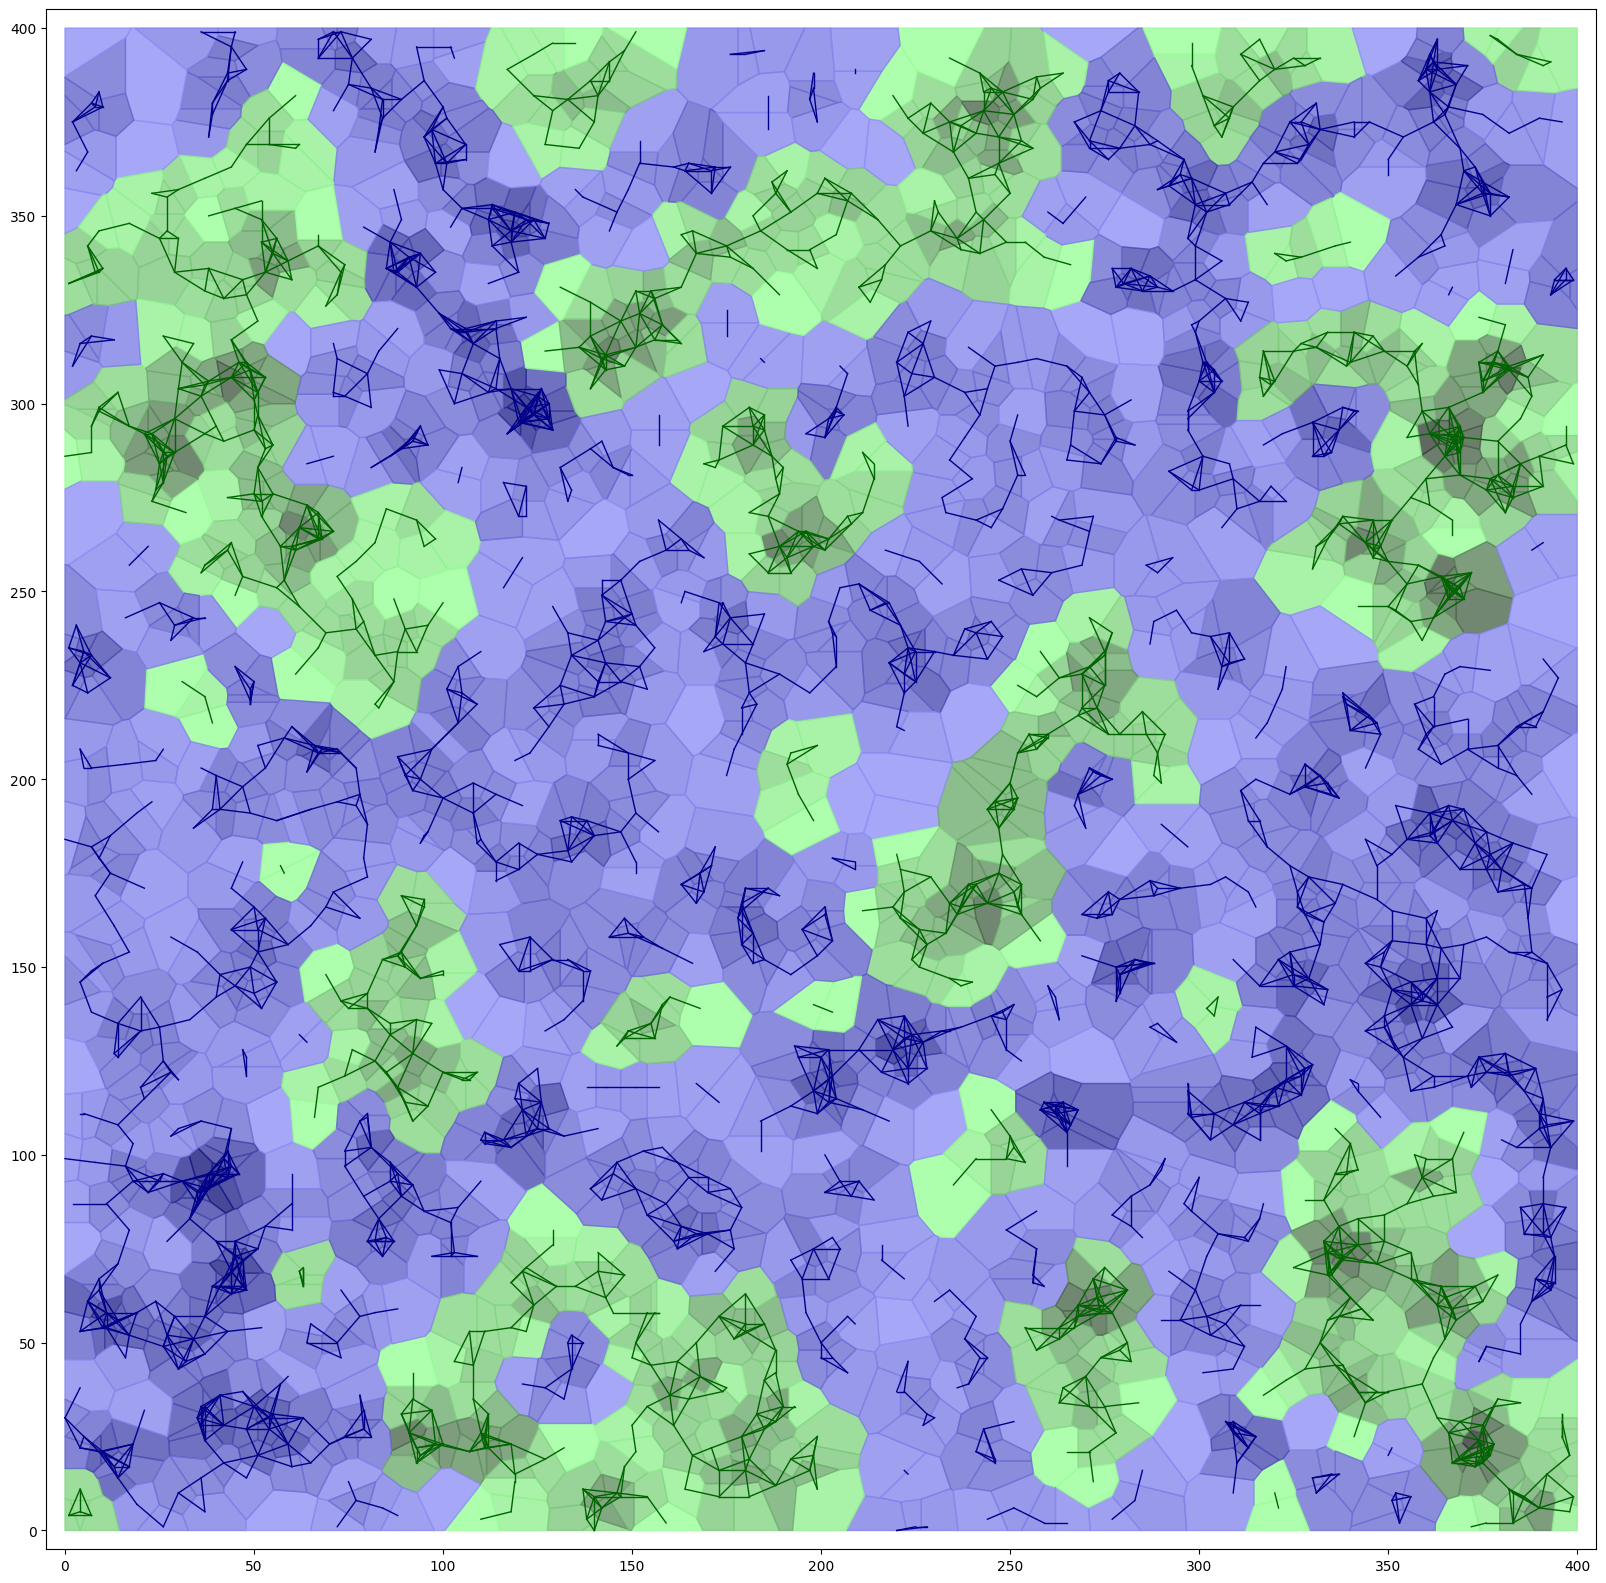

In [42]:
cmap = plt.get_cmap('gist_rainbow')
cmap = plt.get_cmap('summer')
scmap = plt.get_cmap('cool')
#cmap = plt.get_cmap('gist_ncar')
#cmap = plt.get_cmap('nipy_spectral')
#cmap = plt.get_cmap('jet')

fig=plt.figure(figsize=(20,20))
ax = plt.gca()

for cell, data in cell_dict.items():
    if data['height']>=sea_level:
        cvalue = land_colors_cmap(land_heightnorm(data['height']))
    else:
        cvalue = sea_colors_cmap(sea_heightnorm(data['height']))
    patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)
    ax.add_patch(patch)


for f,t in dg.edges():
    if cell_region_colour_lookup.get(f,6)==0:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkgreen',linewidth=1)
    elif cell_region_colour_lookup.get(f,6)==1:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkblue',linewidth=1)

plt.xlim(-5,405)
plt.ylim(-5,405)

In [43]:
cell_dict[0]

{'region': 0,
 'bicolour': 1,
 'height': -5,
 'shape': array([[319.5       , 170.75      ],
        [320.5       , 168.        ],
        [330.        , 168.        ],
        [330.94444444, 168.31481481],
        [331.21428571, 169.21428571],
        [325.36206897, 173.60344828],
        [319.5       , 171.92857143]]),
 'neighbors': [607, 1209, 1870, 118, 1469, 1495, 92],
 'link_neighbors': [92, 1209, 1495, 1870],
 'v_point': array([326., 170.]),
 'vertex_indices': [2360, 855, 856, 373, 845, 846, 2359],
 'vertex_pos': [array([331.21428571, 169.21428571]),
  array([325.36206897, 173.60344828]),
  array([319.5       , 171.92857143]),
  array([319.5 , 170.75]),
  array([320.5, 168. ]),
  array([330., 168.]),
  array([330.94444444, 168.31481481])]}

In [44]:
set(cell_dict[0]['neighbors']).difference(set(cell_dict[0]['link_neighbors']))

{118, 607, 1469}

In [45]:
cell_dict[1589]

{'region': 30,
 'bicolour': 1,
 'height': -5,
 'shape': array([[234.20351759, 223.49497487],
        [231.32222222, 227.61111111],
        [233.36842105, 237.84210526],
        [238.25      , 235.75      ],
        [239.7       , 234.3       ],
        [238.734375  , 225.609375  ]]),
 'neighbors': [140, 409, 960, 1009, 1472, 1797],
 'link_neighbors': [140, 409, 960, 1797],
 'v_point': array([235., 233.]),
 'vertex_indices': [1531, 893, 894, 871, 870, 1530],
 'vertex_pos': [array([239.7, 234.3]),
  array([238.734375, 225.609375]),
  array([234.20351759, 223.49497487]),
  array([231.32222222, 227.61111111]),
  array([233.36842105, 237.84210526]),
  array([238.25, 235.75])]}

In [46]:
[(k,v) for k,v in border_facets.items() if 1589 in v]

[((870, 871), [140, 1589]),
 ((870, 1530), [409, 1589]),
 ((1530, 1531), [960, 1589]),
 ((871, 894), [1009, 1589]),
 ((893, 894), [1472, 1589]),
 ((893, 1531), [1589, 1797])]

In [47]:
assert False

AssertionError: 

In [ ]:
fig=plt.figure(figsize=(20,20))
ax = plt.gca()
live_regions = [vor.regions[r] for r in vor.point_region[0:number_of_points]]
shapes=[]
land_patches=[]
sea_patches=[]
for e,r in enumerate(live_regions) :
    #print(e,r)
    shape=[]
    for v in r:
        shape.append(vor.vertices[v])

    lpatch=mpatches.Polygon(np.array(shape))

    
    #lpatch.set_color(mcolors.to_rgb(clist[cell_region_colour_lookup.get(e,6)]))
    if cell_region_colour_lookup.get(e,6)==0:
        land_patches.append(lpatch)
    elif cell_region_colour_lookup.get(e,6)==1:
        sea_patches.append(lpatch)
    #ax.add_patch(lpatch)
    #ax.text(*vor.points[e],e, fontsize=8, color='white')
    shapes.append(np.array(shape))

pcollection=PatchCollection(land_patches, edgecolor='green', color='forestgreen', alpha=0.4)
ax.add_collection(pcollection)
pcollection=PatchCollection(sea_patches, edgecolor='blue', color='cornflowerblue', alpha=0.4)
ax.add_collection(pcollection)

for f,t in dg.edges():
    if cell_region_colour_lookup.get(f,6)==0:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkgreen',linewidth=1)
    elif cell_region_colour_lookup.get(f,6)==1:
        x1y1=vor.points[f][0], vor.points[f][1]
        x2y2=vor.points[t][0], vor.points[t][1]
        #plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkblue',linewidth=1)
plt.xlim(-5,405)
plt.ylim(-5,405)

In [ ]:
shape